# Statistical data depth in deep learning: Application to out of distribution detection

Brief overview of the Methodology employed in this Jupyter Notebook : 

1. Train VAE: Train the VAE on a dataset to learn the latent space representation.
2. Obtain Latent Representations: Pass the dataset through the trained VAE to obtain the latent space representations.
3. Compute Data Depth: Use the latent space representations to compute data depth, identifying outliers/anomalies based on their depth values. Set a threshold for the data depth to classify points as normal or anomalous. 
4. Visualization: Visualize the latent space with anomalies highlighted based on data depth, and validate the approach with both normal and anomalous data points.

## Importing Required Libraries

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
# for building and training the VAE model
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

# for reproducibility
torch.manual_seed(0)

/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <5310731F-64FC-310E-B88B-E06F64BB3F98> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# for applying data depth and visualizing results
from visualization_core import *
from depth.multivariate import *
from numpy.random import RandomState
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Training the Variational Autoencoder Model

In [4]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim1, hidden_dim2, z_dim=10):
        super(VAE, self).__init__()

        # we could add additional layers 
        self.encoder = nn.Sequential(
            nn.Linear(x_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, z_dim * 2)  # Ensure this outputs twice the latent_dim for mu and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, x_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), z, mu, logvar

In [5]:
# Load Fashion-MNIST dataset
def load_data(normal_class=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
    fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
    
    # Filter out only the normal class
    train_indices = [i for i, (_, label) in enumerate(fashion_mnist_train) if label == normal_class]
    normal_train = Subset(fashion_mnist_train, train_indices)
    
    return normal_train, fashion_mnist_test

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train VAE
def train_model(model, dataloader, learning_rate, num_epochs, max_batches=None):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for bno, batch in enumerate(dataloader):
            if max_batches != None and bno > max_batches :
                break
            x, _ = batch
            x = x.view(x.size(0), -1)
            optimizer.zero_grad()
            recon_x, z, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}')
    return model

In [6]:
# load the fashion MNIST dataset
normal_train, fashion_mnist_test = load_data(normal_class=0)  # Class 0: T-shirt/top
dataloader = DataLoader(normal_train, batch_size=128, shuffle=False)

# define VAE model
x_dim = 28 * 28
hidden_dim1 = 512
hidden_dim2 = 256
latent_dim = 3 
model = VAE(x_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, z_dim=latent_dim)

# train the model
MAX_STEPS = None # goes up until 10000
trained_model = train_model(model, dataloader, learning_rate=1e-4, num_epochs=15, max_batches=MAX_STEPS)

Epoch 1, Loss: 482.0073287760417
Epoch 2, Loss: 362.9761354166667
Epoch 3, Loss: 338.03618815104164
Epoch 4, Loss: 329.74879557291666
Epoch 5, Loss: 321.0464694010417
Epoch 6, Loss: 310.32931770833335
Epoch 7, Loss: 304.21485416666667
Epoch 8, Loss: 301.44381705729165
Epoch 9, Loss: 299.58930924479165
Epoch 10, Loss: 298.28309114583334
Epoch 11, Loss: 297.3702740885417
Epoch 12, Loss: 296.58744140625
Epoch 13, Loss: 295.5748782552083
Epoch 14, Loss: 294.81948958333334
Epoch 15, Loss: 294.26727213541665


## Obtain latent representations

In [7]:
# initialize lists to store latent space and their true labels
latent_space = []
labels = []

trained_model.eval()
sample_no = 1 # in case MAX_STEPS is defined

with torch.no_grad():
    for batch in fashion_mnist_test:
        if MAX_STEPS != None and sample_no > MAX_STEPS : 
            break
        x, y = batch
        x = x.view(-1, x.size(0))
        _, z, _, _ = trained_model(x)
        latent_space.append(z.cpu().numpy())
        labels.append(torch.tensor(y).cpu().numpy())
        sample_no += 1
    
latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate([labels], axis=0)

In [8]:
# SANITY CHECK
print(latent_space.shape) # (10000, 3)
print(labels.shape) # (10000,)

(10000, 3)
(10000,)


## Compute Data Depth for points in Latent Space
Here, we use L2 depth since it's the fastest, but other definitions could also be used. For a full list of the depth definitions, see https://data-depth.github.io/index.html#contents.

In [9]:
# use multivariate library to compute data depth
depths = spatial(latent_space, latent_space)

# SANITY CHECK
print("Number of points:", len(depths)) # 10000
print(np.min(depths), np.max(depths))
print(np.std(depths))

Number of points: 10000
0.03976266539252871 0.9528853364958756
0.17370466079234456


In [10]:
# Set a threshold for anomalies (e.g., top 0.5% furthest points)
threshold = np.percentile(depths, 0.5)
print(threshold)

0.07019434229670497


In [11]:
# get anomalies
anomalies = depths <= threshold
print("Found", len(np.where(anomalies)[0]), "anomalies.")

Found 50 anomalies.


If the number of anomalies is < 10 or > 100, adjust threshold values for better visualizations

In [12]:
# Construct dataframe with depth column
df = pd.DataFrame(latent_space, columns=['x', 'y', 'z'])
df['depth'] = depths
df.head()

,x,y,z,depth
0,0.032926,-0.275808,-0.399118,0.522267
1,-1.007747,0.075005,-2.082375,0.340807
2,0.665443,1.036185,3.907144,0.206470
3,0.010143,0.383964,3.204973,0.226066
4,-0.919357,-0.063840,-1.044403,0.641358


## Visualization 

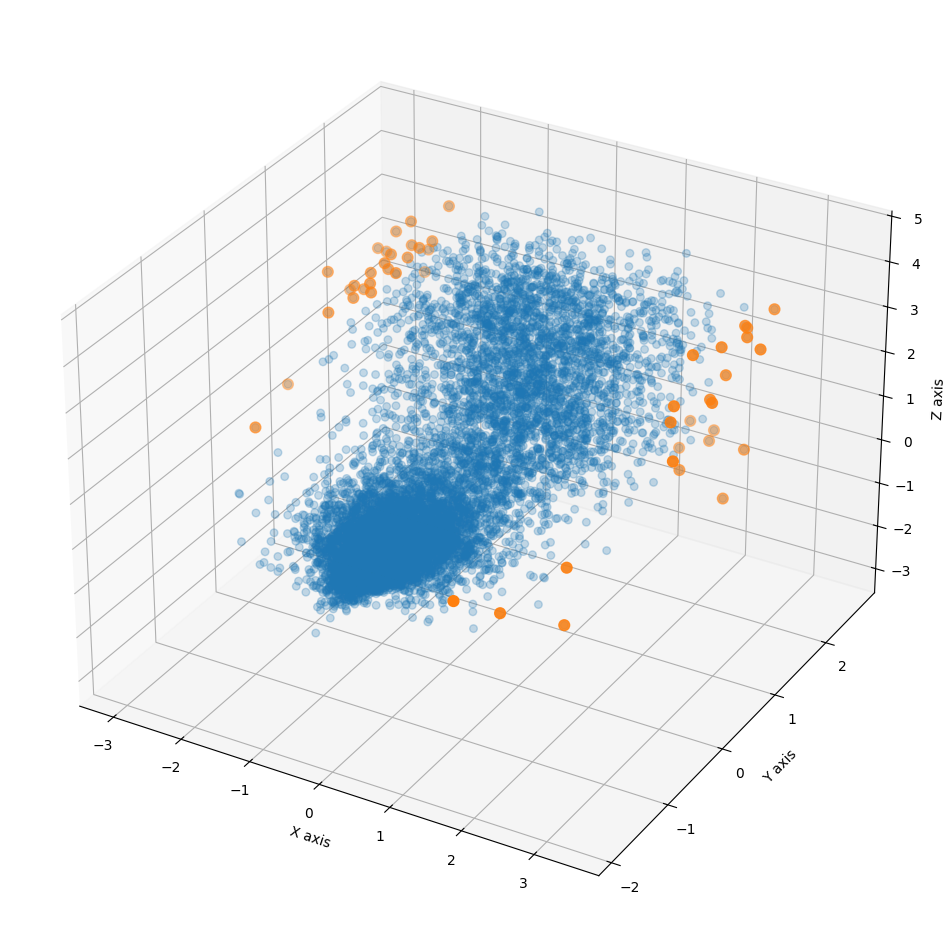

In [13]:
# Check the distribution of anomalies visually
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

s_def = [30 for i in range(len(latent_space))]
s_anom = [60 for i in range(len(latent_space[anomalies, 0]))]

ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], marker= 'o', s=s_def, label='Normal', alpha = 0.25)
ax.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], latent_space[anomalies, 2], marker='o', s = s_anom, label='Anomalies')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.view_init(elev=30)

In [14]:
# Try a different tolerance for a more gradual progression
parts = split_dataframe_by_tolerance(df, "depth", 3*threshold)[::-1]
print(len(parts))
p = [len(part) for part in parts]
print(p)

5
[21, 578, 2299, 4126, 2976]


Plotting part 1/5
Plotting part 2/5
Plotting part 3/5
Plotting part 4/5
Plotting part 5/5


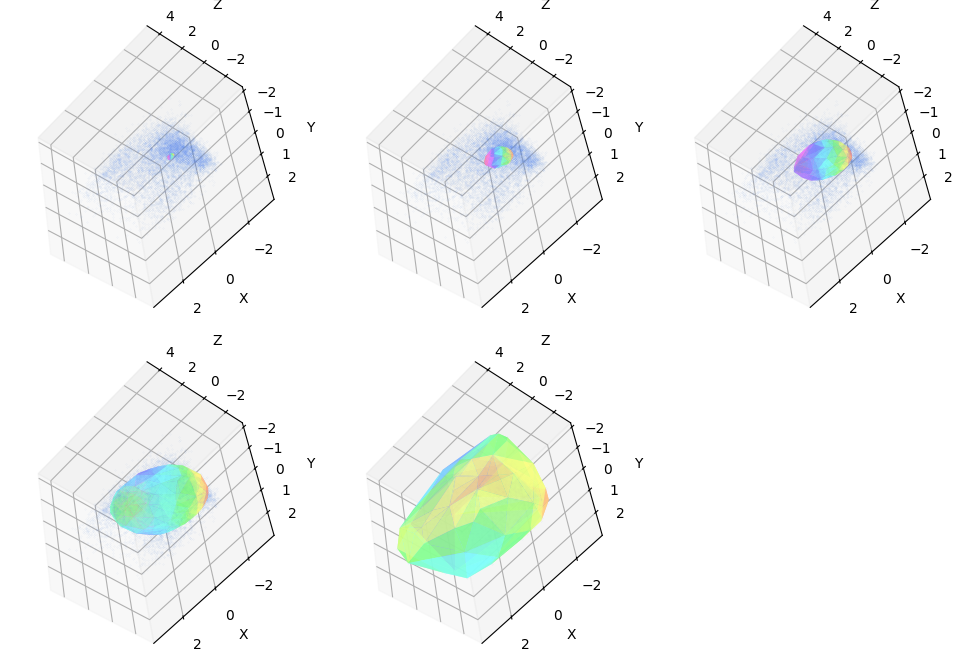

In [15]:
# Show convex hull progression with different threshold values
convex_hull_progression(df, 3*threshold)

In [16]:
# Try a different tolerance for a more gradual progression
parts = split_dataframe_by_tolerance(df, "depth", threshold)[::-1]
print(len(parts))

13


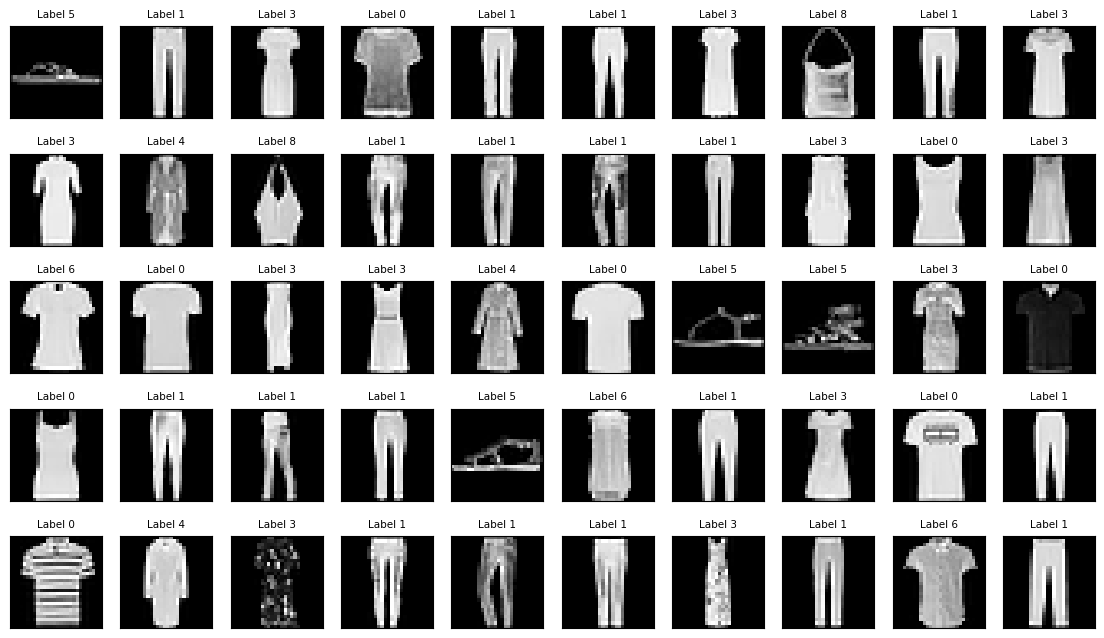

In [24]:
# Check anomalies identified visually
anomaly_indices = np.where(anomalies)[0]

# only 30 anomalies for now
fig, axes = plt.subplots(5, 10, figsize=(14, 8))
ind, row = 0, 0
for i in anomaly_indices[:50]:  
    if ind == 10 : 
        ind = 0
        row += 1
    original = fashion_mnist_test[i][0].view(28, 28).numpy()
    with torch.no_grad():
        org = fashion_mnist_test[i][0]
        reconstructed, _, _, _ = trained_model(org.view(-1, org.size(0)))
    reconstructed = reconstructed.view(28, 28).numpy()
    axes[row, ind].get_xaxis().set_ticks([])
    axes[row, ind].get_yaxis().set_ticks([])
    axes[row, ind].imshow(original, cmap='gray')
    axes[row, ind].set_title('Label ' + str(labels[i]), fontsize=7.5)
    ind += 1

plt.show()

In [25]:
misclassified = 0
for i in anomaly_indices : 
    if labels[i] == 0 :
        misclassified += 1

print(misclassified, "examples were misclassified as anomalies.")

8 examples were misclassified as anomalies.
